# Analyzing NYC Highschool Data

The purpose of this project is to analyze NYC Highschool data to see if there is a correlation between different factors such as Race and Gender and Higher SAT Scores

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [22]:
# descriptive names
column_name={
"dbn":"School identification code",
"N_p":"NUMBER OF RESPONDENTS_Parents",
"N_s":"NUMBER OF RESPONDENTS_Students",
"N_t":"NUMBER OF RESPONDENTS_Teachers",
"aca_p_11":"Academic expectation score from Parent's response",
"aca_s_11":"Academic expectation score from Student's response",
"aca_t_11":"Academic expectation score from Teacher's response",
"aca_tot_11":"Academic expectation score Total",
"com_p_11":"Communication score from Parent's response",
"com_s_11":"Communication score from Student',s response",
"com_t_11":"Communication score from Teacher' response",
"com_tot_11":"Communication score Total",
"eng_p_11":"Engagement score from Parent's response",
"eng_s_11":"Engagement score from Student's response",
"eng_t_11":"Engagement score from Teacher's response",
"eng_tot_11":"Engagement score Total",
"rr_p":"Resonse rate_Parents",
"rr_s":"Resonse rate_Students",
"rr_t":"Resonse rate_Teachers",
"saf_p_11":"Safety and Respect score from Parent's response",
"saf_s_11":"Safety and Respect score from Students's response",
"saf_t_11":"Safety and Respect score from Teacher's response",
"saf_tot_11":"Safety and Respect score Total"
}
col_df =pd.DataFrame({"description":column_name})
col_df

,description
N_p,NUMBER OF RESPONDENTS_Parents
N_s,NUMBER OF RESPONDENTS_Students
N_t,NUMBER OF RESPONDENTS_Teachers
aca_p_11,Academic expectation score from Parent's response
aca_s_11,Academic expectation score from Student's resp...
aca_t_11,Academic expectation score from Teacher's resp...
aca_tot_11,Academic expectation score Total
com_p_11,Communication score from Parent's response
com_s_11,"Communication score from Student',s response"
com_t_11,Communication score from Teacher' response


# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Create a bar plot of correlations between these fields and sat_score

In [11]:
%matplotlib inline
print(survey_fields)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


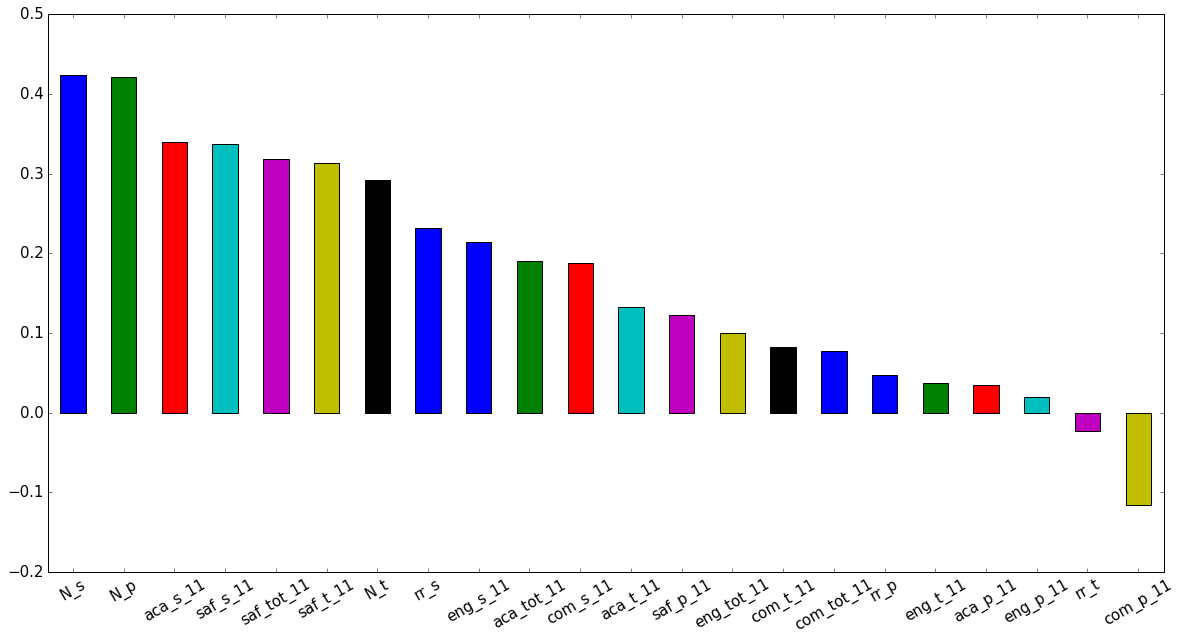

In [25]:
combined.corr()['sat_score'][survey_fields].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,10), rot = 30, fontsize = 15)

In [26]:
col_df

,description
N_p,NUMBER OF RESPONDENTS_Parents
N_s,NUMBER OF RESPONDENTS_Students
N_t,NUMBER OF RESPONDENTS_Teachers
aca_p_11,Academic expectation score from Parent's response
aca_s_11,Academic expectation score from Student's resp...
aca_t_11,Academic expectation score from Teacher's resp...
aca_tot_11,Academic expectation score Total
com_p_11,Communication score from Parent's response
com_s_11,"Communication score from Student',s response"
com_t_11,Communication score from Teacher' response


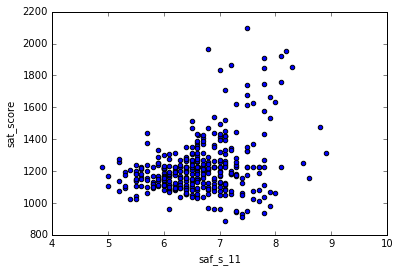

In [27]:
combined.plot.scatter( x= 'saf_s_11', y = 'sat_score')

# It seems there is a bit of positive correlations based on this scatter plot

In [34]:
combined.groupby('boro').agg(numpy.mean)['saf_s_11'].sort_values(ascending = False)

boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64

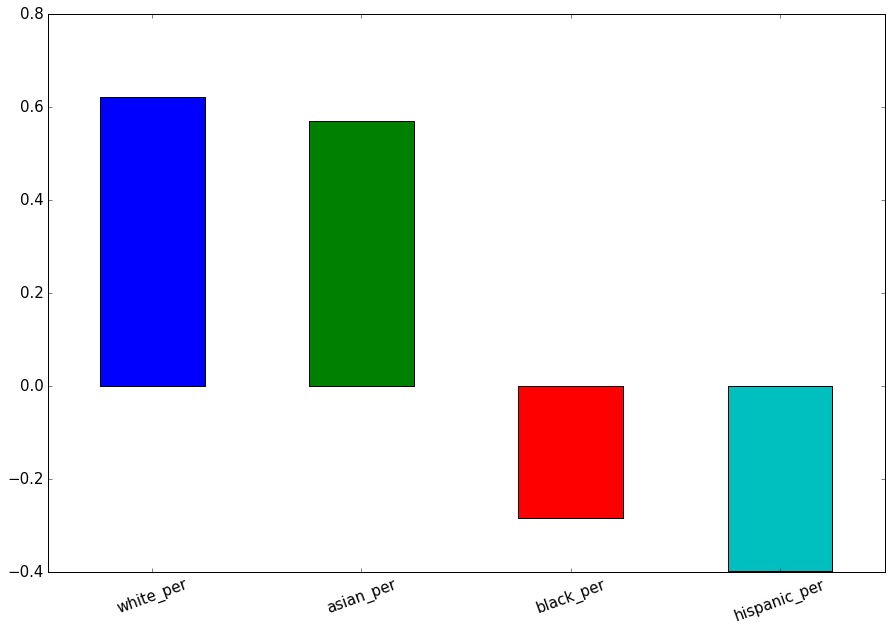

In [40]:
race_percentages = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

combined.corr()['sat_score'][race_percentages].plot(kind = 'bar', figsize = (15,10), rot = 20, fontsize = 15)

# Analysis

Schools with a higher percentage of white and asian kids seem to do better than schools with higher perctage of black or hispanic kids. This is likely due to the lack of funding in schools with primariliy black or hispanic kids.

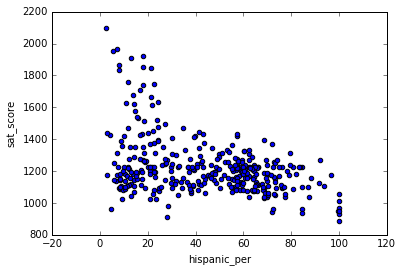

In [41]:
combined.plot.scatter(x= 'hispanic_per', y = 'sat_score')

# This scatter plot demonstrates that schools with a higher percentage of hispanics have lower sat scores

In [43]:
# look for schools with a hispanic population of greater than 95%
hisp_max = combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]
print(hisp_max)

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


# From a google search, all of these schools are seem to be relatively low budget. We can tell this by looking at the exterior of these schools which look run down or abandoned

In [45]:
hisp_max = combined[(combined["hispanic_per"] < 10) & (combined['sat_score'] > 1800)]["SCHOOL NAME"]
print(hisp_max)

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


# From another google search, all of these schools are highly rated and seem to have noteriety for preparing students to be successful. We can conclude that schools with higher funding which are primarily attended by white and asian students have higher sat scores than students going to schools with lower funding usually attended by hispanics and blacks

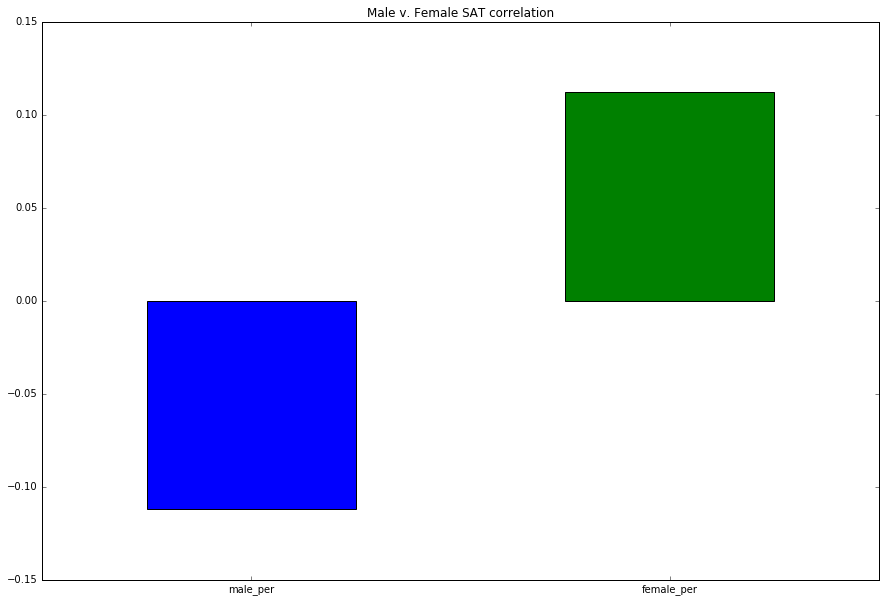

In [52]:
#Investigating gender and sat score correlations
morf = ['male_per','female_per']
combined.corr()['sat_score'][morf].plot(kind = 'bar', figsize = (15,10), title='Male v. Female SAT correlation', rot = 0)

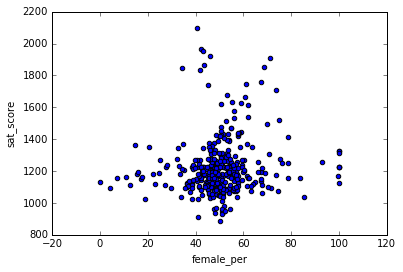

In [53]:
combined.plot.scatter(x = 'female_per', y = 'sat_score')

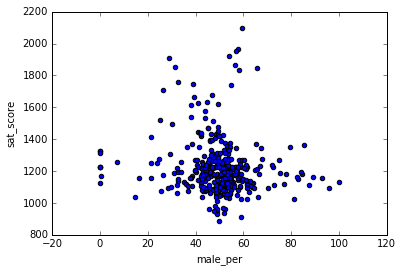

In [54]:
combined.plot.scatter(x = 'male_per', y = 'sat_score')

# From both of these scatter plots it seems that there is not much correlation between higher sat scores and gender.

In [55]:
female_max = combined[(combined["female_per"] > 60) & (combined['sat_score'] > 1700)]["SCHOOL NAME"]
print(female_max)

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


# These schools seem to be in prestigious districts where there is alot of funding and famous people have graduated from these schools such as Jennifer Aniston and Nikki Minaj

In [57]:
# Calculating percentage of students in each school that took an AP Exam

combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

In [58]:
combined['ap_per'].head()

0    0.305756
1    0.098985
2    0.031773
3    0.351577
4    0.158091
Name: ap_per, dtype: float64

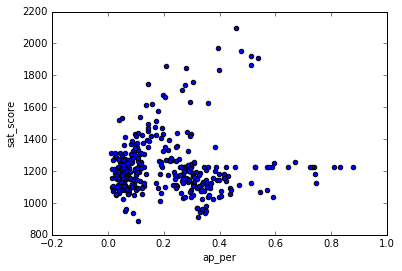

In [59]:
combined.plot.scatter(x = 'ap_per', y = 'sat_score')

# There seems to be some correlation between the percentage of students who took an ap exam and higher SAT scores. This makes sense because ap exams are college level classes and the SAT is a college admissions exam.

# Final Analysis

While the data doesn't lie in that whites and asians tend to have higher SAT scores, there are plenty of other factors at play here. First of all schools with more funding tend to have higher SAT scores, schools that are focused on preparing student for college also tend to have higher SAT scores. We also noted that there isn't much of a difference between boys and girls SAT scores.